# Task 1: Setting the Baseline 
## Task 1.1 Data Preparation and Validation Pipeline

In [1]:
import pandas as pd 
import numpy as np

df_raw_train = pd.read_csv("./kaggle/input/3bodyproblem/mlNOVA/mlNOVA/X_train.csv")
df_raw_test = pd.read_csv("./kaggle/input/3bodyproblem/mlNOVA/mlNOVA/X_test.csv")

### Check for any missing values

In [ ]:
print("Summary of the missing\nvalues in the training set\n")
print(df_raw_train.isna().sum())
print()

print("Summary of the missing\nvalues in the test set\n")
print(df_raw_test.isna().sum())

### Visualize few trajectories

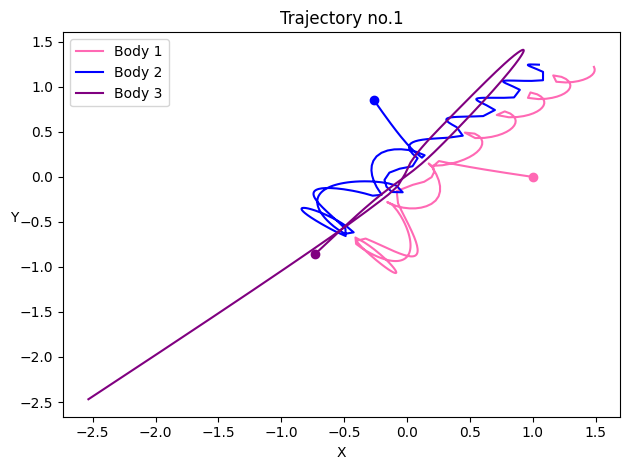

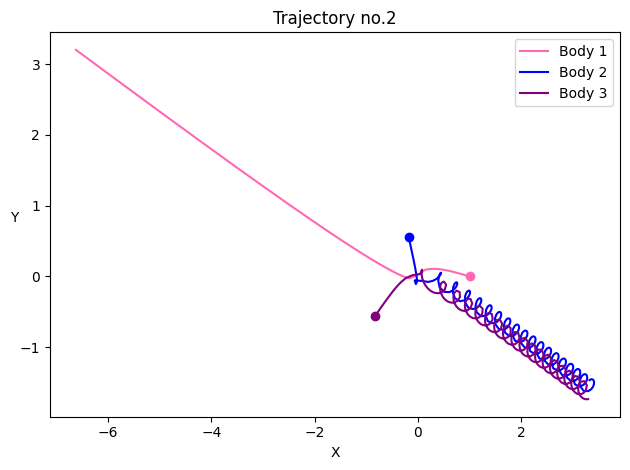

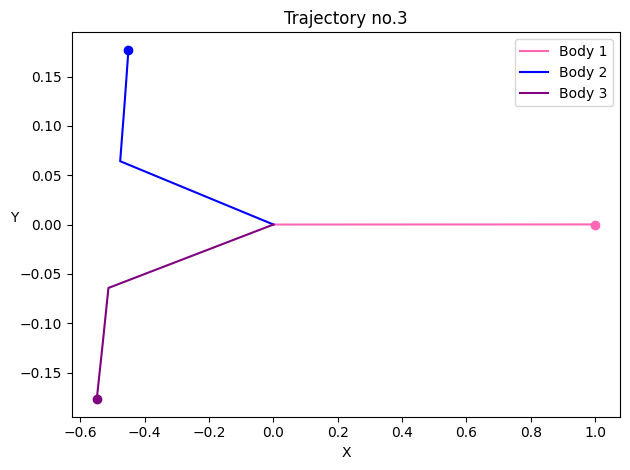

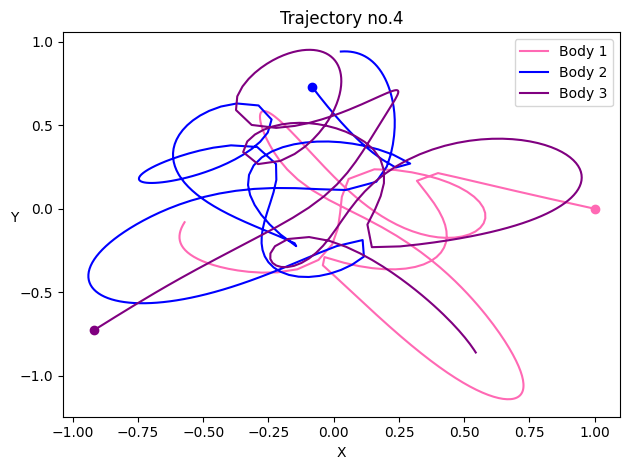

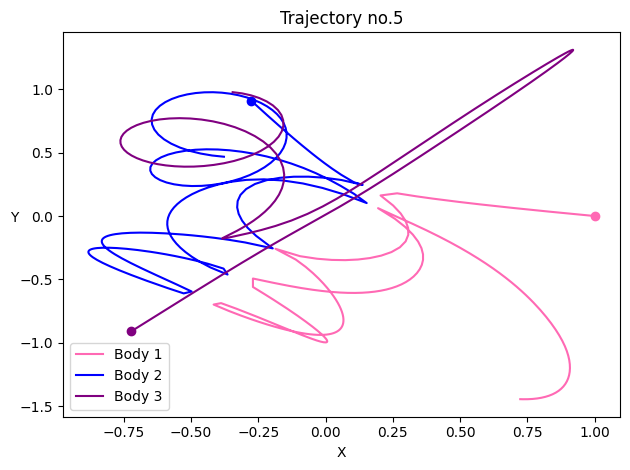

In [26]:
import matplotlib.pyplot as plt

start = 0
end = 257

for i in range(5):
    trajectory = df_raw_train[start:end]
    x1, y1, x2, y2, x3, y3 = trajectory.x_1, trajectory.y_1, trajectory.x_2, trajectory.y_2, trajectory.x_3, trajectory.y_3
    plt.plot(x1, y1, color="hotpink", label = "Body 1")
    plt.plot(x2, y2, color="blue", label = "Body 2")
    plt.plot(x3, y3, color="purple", label = "Body 3")
    plt.scatter(x1[start], y1[start], color="hotpink")
    plt.scatter(x2[start], y2[start], color="blue")
    plt.scatter(x3[start], y3[start], color="purple")
    plt.xlabel("X")
    plt.ylabel("Y", rotation=0)
    plt.title("Trajectory no." + str(i+1))
    plt.legend()
    plt.tight_layout()
    plt.show()

    start += 257
    end += 257


### Prepare the dataset

In [2]:
df_raw_train["group"] = df_raw_train["Id"]//257

In [3]:
#All starting positions
df_init = df_raw_train[ df_raw_train.index%257 == 0]

In [4]:
df_combined = df_raw_train.merge(df_init, on="group",  suffixes=('', '_init'))

# Step 1: Create a list/array of unique group_ids
unique_groups = df_combined['Id_init'].unique()

# Step 2: Create a random mask for this list
mask_train_test = np.random.rand(len(unique_groups)) < 0.8  # random True/False values

# Step 3: Split unique groups into two sets
group_train = unique_groups[mask_train_test]  # groups for the training set
group_testing = unique_groups[~mask_train_test]  # groups for the test set

# Step 4: Use the mask to split the DataFrame
train_set = df_combined[df_combined['Id_init'].isin(group_train)]
testing_set = df_combined[df_combined['Id_init'].isin(group_testing)]


unique_groups_train_validation = testing_set['Id_init'].unique()

mask_val_test = np.random.rand(len(unique_groups_train_validation)) < 0.5

group_validation = unique_groups_train_validation[mask_val_test]  # groups for the training set
group_test = unique_groups_train_validation[~mask_val_test]  # groups for the test set

validation_set = testing_set[testing_set['Id_init'].isin(group_validation)]
test_set = testing_set[testing_set['Id_init'].isin(group_test)]



### Remove following zeros after bodies collision (optional)

In [5]:
# train_set = train_set.drop_duplicates(subset=[col for col in train_set.columns if col != 'id'])
# train_set.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,...,v_y_1_init,x_2_init,y_2_init,v_x_2_init,v_y_2_init,x_3_init,y_3_init,v_x_3_init,v_y_3_init,Id_init
257,0.000000,1.000000,0.000000,0.000000,0.000000,-0.176502,0.555739,0.000000,0.000000,-0.823498,...,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
258,0.039062,0.999392,0.000131,-0.031160,0.006723,-0.176326,0.555148,0.008985,-0.030279,-0.823065,...,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
259,0.078125,0.997564,0.000525,-0.062415,0.013460,-0.175799,0.553372,0.017992,-0.060639,-0.821765,...,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
260,0.117188,0.994513,0.001183,-0.093859,0.020224,-0.174920,0.550408,0.027043,-0.091163,-0.819593,...,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
261,0.156250,0.990228,0.002106,-0.125591,0.027029,-0.173686,0.546247,0.036162,-0.121934,-0.816542,...,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257


#### Display sets

In [6]:
train_set

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,...,v_y_1_init,x_2_init,y_2_init,v_x_2_init,v_y_2_init,x_3_init,y_3_init,v_x_3_init,v_y_3_init,Id_init
257,0.000000,1.000000,0.000000,0.000000,0.000000,-0.176502,0.555739,0.000000,0.000000,-0.823498,...,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
258,0.039062,0.999392,0.000131,-0.031160,0.006723,-0.176326,0.555148,0.008985,-0.030279,-0.823065,...,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
259,0.078125,0.997564,0.000525,-0.062415,0.013460,-0.175799,0.553372,0.017992,-0.060639,-0.821765,...,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
260,0.117188,0.994513,0.001183,-0.093859,0.020224,-0.174920,0.550408,0.027043,-0.091163,-0.819593,...,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
261,0.156250,0.990228,0.002106,-0.125591,0.027029,-0.173686,0.546247,0.036162,-0.121934,-0.816542,...,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284995,9.843750,-0.022787,-0.354678,-1.450539,-0.511101,-0.128897,-0.618452,1.066492,-0.497032,0.151684,...,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743
1284996,9.882810,-0.082072,-0.384254,-1.556362,-1.038875,-0.084507,-0.627569,1.177829,0.065469,0.166578,...,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743
1284997,9.921880,-0.140434,-0.438907,-1.348462,-1.794786,-0.040823,-0.610311,0.975436,0.853069,0.181257,...,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743
1284998,9.960940,-0.177344,-0.524277,-0.380080,-2.492241,-0.018380,-0.561151,0.012292,1.579595,0.195724,...,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743


In [7]:
validation_set

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,...,v_y_1_init,x_2_init,y_2_init,v_x_2_init,v_y_2_init,x_3_init,y_3_init,v_x_3_init,v_y_3_init,Id_init
2827,0.000000,1.000000,0.000000,0.000000,0.000000,-0.040181,0.516341,0.000000,0.000000,-0.959819,...,0.0,-0.040181,0.516341,0.0,0.0,-0.959819,-0.516341,0.0,0.0,2827
2828,0.039062,0.999313,0.000204,-0.035163,0.010462,-0.039940,0.515791,0.012370,-0.028146,-0.959374,...,0.0,-0.040181,0.516341,0.0,0.0,-0.959819,-0.516341,0.0,0.0,2827
2829,0.078125,0.997251,0.000818,-0.070457,0.020957,-0.039214,0.514141,0.024810,-0.056359,-0.958037,...,0.0,-0.040181,0.516341,0.0,0.0,-0.959819,-0.516341,0.0,0.0,2827
2830,0.117188,0.993806,0.001842,-0.106015,0.031519,-0.038000,0.511386,0.037390,-0.084707,-0.955806,...,0.0,-0.040181,0.516341,0.0,0.0,-0.959819,-0.516341,0.0,0.0,2827
2831,0.156250,0.988964,0.003281,-0.141977,0.042183,-0.036290,0.507520,0.050185,-0.113259,-0.952673,...,0.0,-0.040181,0.516341,0.0,0.0,-0.959819,-0.516341,0.0,0.0,2827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281397,9.843750,1.322500,-0.529554,-0.079365,-0.154615,-0.372044,0.534657,0.095746,0.768892,-0.950456,...,0.0,-0.290487,0.906441,0.0,0.0,-0.709513,-0.906441,0.0,0.0,1281145
1281398,9.882810,1.319103,-0.535461,-0.094551,-0.147799,-0.368994,0.563772,0.061330,0.722149,-0.950109,...,0.0,-0.290487,0.906441,0.0,0.0,-0.709513,-0.906441,0.0,0.0,1281145
1281399,9.921880,1.315115,-0.541100,-0.109607,-0.140960,-0.367187,0.591099,0.031985,0.677293,-0.947929,...,0.0,-0.290487,0.906441,0.0,0.0,-0.709513,-0.906441,0.0,0.0,1281145
1281400,9.960940,1.310541,-0.546473,-0.124557,-0.134103,-0.366443,0.616707,0.006712,0.634085,-0.944099,...,0.0,-0.290487,0.906441,0.0,0.0,-0.709513,-0.906441,0.0,0.0,1281145


In [8]:
test_set

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,...,v_y_1_init,x_2_init,y_2_init,v_x_2_init,v_y_2_init,x_3_init,y_3_init,v_x_3_init,v_y_3_init,Id_init
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,...,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,...,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,...,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,...,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,...,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284224,9.843750,0.431058,0.202489,-0.668326,-0.496782,-0.504008,0.599934,0.350354,0.004134,0.072950,...,0.0,-0.219173,0.616222,0.0,0.0,-0.780827,-0.616222,0.0,0.0,1283972
1284225,9.882810,0.404034,0.182732,-0.715625,-0.514987,-0.489504,0.599484,0.392538,-0.027626,0.085471,...,0.0,-0.219173,0.616222,0.0,0.0,-0.780827,-0.616222,0.0,0.0,1283972
1284226,9.921880,0.375123,0.162235,-0.764920,-0.534787,-0.473315,0.597739,0.436673,-0.062222,0.098192,...,0.0,-0.219173,0.616222,0.0,0.0,-0.780827,-0.616222,0.0,0.0,1283972
1284227,9.960940,0.344247,0.140925,-0.816290,-0.556647,-0.455360,0.594578,0.483009,-0.100261,0.111113,...,0.0,-0.219173,0.616222,0.0,0.0,-0.780827,-0.616222,0.0,0.0,1283972


### Verify dataset splitting

In [9]:
# Get sorted unique Id_init values
unique_sorted_ids_train = sorted(set(train_set['Id_init'].values))
unique_sorted_ids_val = sorted(set(validation_set['Id_init'].values))
unique_sorted_ids_test = sorted(set(test_set['Id_init'].values))

# Find intersection of the two sets
intersection_ids1 = sorted(set(unique_sorted_ids_train) & set(unique_sorted_ids_val))
intersection_ids2 = sorted(set(unique_sorted_ids_train) & set(unique_sorted_ids_test))
intersection_ids3 = sorted(set(unique_sorted_ids_test) & set(unique_sorted_ids_val))

# Display the results]
print("Intersection of IDs:", intersection_ids1)
print("Intersection of IDs:", intersection_ids2)
print("Intersection of IDs:", intersection_ids3)

Intersection of IDs: []
Intersection of IDs: []
Intersection of IDs: []


### Prepare input and output sets

In [10]:
input_train = train_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
input_validation = validation_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
input_test = test_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
input_submission = df_raw_test.drop(columns=["Id"]).rename(columns={"t": "t", "x0_1": "x_1_init", "y0_1": "y_1_init", "x0_2": "x_2_init", "y0_2": "y_2_init", "x0_3": "x_3_init", "y0_3": "y_3_init"})
input_submission.head()

,t,x_1_init,y_1_init,x_2_init,y_2_init,x_3_init,y_3_init
0,0.000000,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
1,0.039062,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
2,0.078125,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
3,0.117188,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
4,0.156250,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085


In [11]:
input_validation.head()

,t,x_1_init,y_1_init,x_2_init,y_2_init,x_3_init,y_3_init
2827,0.000000,1.0,0.0,-0.040181,0.516341,-0.959819,-0.516341
2828,0.039062,1.0,0.0,-0.040181,0.516341,-0.959819,-0.516341
2829,0.078125,1.0,0.0,-0.040181,0.516341,-0.959819,-0.516341
2830,0.117188,1.0,0.0,-0.040181,0.516341,-0.959819,-0.516341
2831,0.156250,1.0,0.0,-0.040181,0.516341,-0.959819,-0.516341


In [12]:
output_train = train_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
output_validation = validation_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
output_test = test_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]

output_train.head()

,x_1,y_1,x_2,y_2,x_3,y_3
257,1.000000,0.000000,-0.176502,0.555739,-0.823498,-0.555739
258,0.999392,0.000131,-0.176326,0.555148,-0.823065,-0.555279
259,0.997564,0.000525,-0.175799,0.553372,-0.821765,-0.553898
260,0.994513,0.001183,-0.174920,0.550408,-0.819593,-0.551591
261,0.990228,0.002106,-0.173686,0.546247,-0.816542,-0.548353


In [13]:
output_validation.head()


,x_1,y_1,x_2,y_2,x_3,y_3
2827,1.000000,0.000000,-0.040181,0.516341,-0.959819,-0.516341
2828,0.999313,0.000204,-0.039940,0.515791,-0.959374,-0.515995
2829,0.997251,0.000818,-0.039214,0.514141,-0.958037,-0.514959
2830,0.993806,0.001842,-0.038000,0.511386,-0.955806,-0.513229
2831,0.988964,0.003281,-0.036290,0.507520,-0.952673,-0.510802


In [14]:
groups = train_set["group"]
groups

257           1
258           1
259           1
260           1
261           1
           ... 
1284995    4999
1284996    4999
1284997    4999
1284998    4999
1284999    4999
Name: group, Length: 1025430, dtype: int64

#### Function to save predictions to csv


In [15]:
def save_predictions_to_csv(predictions: np.ndarray, output_file_name: str):

    """
    Saves the given NumPy array with predictions to a CSV file.

    Parameters:
    - predictions (np.ndarray): A NumPy array containing the data to be saved.
    - output_file_name (str): The name of the output CSV file (without .csv extension).
    """

    predictions_df = pd.DataFrame(predictions, columns=["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"])
    predictions_df.insert(0, 'Id', range(len(predictions_df)))
    predictions_df.to_csv("./output/csv/"+output_file_name+".csv", index=False)

### Drop columns (optional)

In [474]:
# columns=["y_3_init","x_3_init"]
# test_set=test_set.drop(columns=columns)
# input_test=input_test.drop(columns=columns)
# input_validation=input_validation.drop(columns=columns)
# input_train=input_train.drop(columns=columns)
# input_submission=input_submission.drop(columns=columns)

In [ ]:
input_validation.head()

## Task 1.2 Learn the baseline model

In [182]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(random_state=1, max_iter=3)
svm = SVR(kernel="linear")
model = LinearRegression()
modelRidge = Ridge()
modelLasso = Lasso()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", model)
    ])
pipe

In [ ]:
from sklearn.metrics import root_mean_squared_error
    
pipe.fit(input_train, output_train)
y_hat = pipe.predict(input_validation)
y_hat_test = pipe.predict(input_test)
y_hat_submission = pipe.predict(input_submission)
save_predictions_to_csv(y_hat_test, "baseline_test")
save_predictions_to_csv(y_hat_submission, "baseline-model")
rmse = root_mean_squared_error(output_validation, y_hat)
rmse_test = root_mean_squared_error(output_test, y_hat_test)

print("RMSE: ", rmse)
print("RMSE Test: ", rmse_test)

### Tests for dropping values (optional)

In [ ]:
import itertools
# List to store results
results = []
rmse_base=rmse
# Columns to consider for dropping
columns = input_train.columns

# Iterate over combinations of 1, 2, and 3 columns
for num_columns in range(1, 4):
    for combo in itertools.combinations(columns, num_columns):
        modified_input = input_train.drop(columns=list(combo))
        pipe.fit(modified_input, output_train)
        y_hat = pipe.predict(input_validation.drop(columns=list(combo)))
        rmse = root_mean_squared_error(output_validation, y_hat)
        results.append((combo, rmse*10000))

# Sort results by RMSE
sorted_results = sorted(results, key=lambda x: x[1])

# Print sorted results
for combo, rmse in sorted_results:
    print(f"Columns dropped: {combo}")
    print(f"RMSE: {(rmse-(rmse_base*10000))}")
    print("-" * 30)

In [19]:
import numpy as np

def plot_y_yhat(y_validation, y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_validation) > MAX:
        idx = np.random.choice(len(y_validation),MAX, replace=False)
    else:
        idx = np.arange(len(y_validation))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_validation[idx,i])
        x1 = np.max(y_validation[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_validation[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.suptitle(plot_title)
    plt.savefig("./output/plots/"+plot_title+'.pdf')
    plt.show()

In [ ]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(y_hat).to_numpy(), plot_title="baseline")


# Task 2: Nonlinear models on the data — the Polynomial Regression model

## Task 2.1 Development

In [496]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,9), max_features=None):
    
    #best_rsme = [1000, 1000, 1000]
    best_degrees_rsmes = [[0, 1000], [0, 1000], [0, 1000]]
    train_scores = []
    validation_scores = []
    n_features_list = []

    for d in degrees:
        print("Degree ", d)

        pipe_d_degree= Pipeline(
    [       ('preprocessor', PolynomialFeatures(degree=d)),
            ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
    ])

        pipe_d_degree.fit(X_train, y_train)

        n_features = pipe_d_degree.named_steps['preprocessor'].n_output_features_
        n_features_list.append(n_features)

        y_train_predict = pipe_d_degree.predict(X_train)
        y_val_predict = pipe_d_degree.predict(X_val)


        train_error = np.sqrt(mean_squared_error(y_train, y_train_predict))
        #print("Train RMSE:", train_error)

        val_error = np.sqrt(mean_squared_error(y_val, y_val_predict))
        print("Val RMSE:", val_error)

        if val_error < best_degrees_rsmes[2][1]:
            best_degrees_rsmes[2][1] = val_error
            best_degrees_rsmes[2][0] = d
            best_degrees_rsmes.sort(key=lambda x: x[1], reverse=False)

        train_scores.append(train_error)
        validation_scores.append(val_error)
    
    best_degrees = [item[0] for item in best_degrees_rsmes]
    best_rsmes = [item[1] for item in best_degrees_rsmes]

    return train_scores, validation_scores, best_rsmes, best_degrees, n_features_list

In [ ]:
degrees=range(1,9)
degree_scores = {d: {'train_scores': [], 'test_scores': []} for d in degrees}
best_rsmes = []
best_degrees = []

for _ in range(10):

    sample_train_set = train_set.sample(frac=0.01)
    sample_input_train = sample_train_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
    sample_output_train = sample_train_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
    
    train_scores, validation_scores, best_rsme, best_degree, n_features_list = validate_poly_regression(sample_input_train, sample_output_train, input_validation, output_validation, degrees=degrees)

    best_rsmes.append(min(best_rsme))
    best_degrees.append(best_degree[0])
    best_degrees.append(best_degree[1])
    best_degrees.append(best_degree[2])

    for d in degrees:
        degree_scores[d]['train_scores'].append(train_scores[d-1])
        degree_scores[d]['test_scores'].append(validation_scores[d-1])

# Save best RMSEs and degrees to CSV
#
# df_best = pd.DataFrame({
#    'best_degree': best_degrees,
#    'best_rsme': best_rsmes
#    
#})

#df_best.to_csv('./output/csv/PR_best_rsme_degrees.csv', index=False)

print(n_features_list)

In [ ]:
import matplotlib.pyplot as plt

# Create bin edges so that each bar is centered on its respective integer
bin_edges = [i - 0.5 for i in range(1, len(degrees) + 2)]  # Create bin edges

plt.hist(best_degrees, bins=bin_edges, color='pink', edgecolor='black')

plt.xticks(range(1, len(degrees) + 1))
plt.yaxis.get_major_locator().set_params(integer=True)

plt.title('Distribution of Selected Polynomial Degrees')
plt.xlabel('Degree')
plt.ylabel('Number of times in TOP3 degrees')

plt.show()

In [ ]:
plt.plot(best_rsmes, color='hotpink')
plt.title('RMSE throughout 10 runs')
plt.xlabel('# of run')
plt.ylabel('RMSE')
plt.show()

### Train with the best-degree model


In [ ]:
#best_degree_ever = max(set(best_degrees), key=best_degrees.count)
best_degree_ever=3
print("Best degree", best_degree_ever)

pipe_best_degree= Pipeline(
[       ('preprocessor', PolynomialFeatures(degree=best_degree_ever)),
        ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

pipe_best_degree.fit(input_train, output_train)

output_train_predict = pipe_best_degree.predict(input_train)
output_val_predict = pipe_best_degree.predict(input_validation)
output_test_predict = pipe_best_degree.predict(input_test)
output_submission_predict = pipe_best_degree.predict(input_submission)

save_predictions_to_csv(output_test_predict, "poly_test")
save_predictions_to_csv(output_submission_predict, "polynomial_submission")

train_error = root_mean_squared_error(output_train, output_train_predict)
print("Train RMSE:", train_error)

val_error = root_mean_squared_error(output_validation, output_val_predict)
print("Validation RMSE:", val_error)

### Train with the 3 best-degree models on more data


In [ ]:
from collections import Counter

top_3_degrees = Counter(best_degrees).most_common(3)

most_frequent_degrees = [degree for degree, count in top_3_degrees]

print("Top 3 most frequent degrees:", sorted(most_frequent_degrees))

In [ ]:
degrees=sorted(most_frequent_degrees)
degree_scores = {d: {'train_scores': [], 'test_scores': []} for d in degrees}
best_rsmes_after_selection = []
best_degrees_after_selection = []

for _ in range(5):

    sample_train_set = train_set.sample(frac=0.35)
    sample_input_train = sample_train_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
    sample_output_train = sample_train_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
    
    train_scores, validation_scores, best_rsme, best_degree, n_features_list = validate_poly_regression(sample_input_train, sample_output_train, input_validation, output_validation, degrees=degrees)

    best_index = best_rsme.index(min(best_rsme))
    best_rsmes_after_selection.append(best_rsme[best_index])
    best_degrees_after_selection.append(best_degree[best_index])

    for d in degrees:
        degree_scores[d]['train_scores'].append(train_scores[d-1])
        degree_scores[d]['test_scores'].append(validation_scores[d-1])

In [ ]:
# Create bin edges so that each bar is centered on its respective integer
bin_edges = [i - 0.5 for i in range(1, len(degrees) + 2)]  # Create bin edges

plt.hist(best_degrees_after_selection, bins=bin_edges, color='pink', edgecolor='black')

plt.xticks(range(1, len(most_frequent_degrees) + 1))
plt.yaxis.get_major_locator().set_params(integer=True)

plt.title('Distribution of Selected Polynomial Degrees')
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.show()

### Train on the best-degree model on all data


In [ ]:
best_degree_ever = max(set(best_degrees), key=best_degrees.count)

print("Best degree", best_degree_ever)

pipe_best_degree= Pipeline(
[       ('preprocessor', PolynomialFeatures(degree=best_degree_ever)),
        ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

pipe_best_degree.fit(input_train, output_train)

output_train_predict = pipe_best_degree.predict(input_train)
output_val_predict = pipe_best_degree.predict(input_validation)

train_error = np.sqrt(mean_squared_error(output_train, output_train_predict))
print("Train RMSE:", train_error)

val_error = np.sqrt(mean_squared_error(output_validation, output_val_predict))
print("Validation RMSE:", val_error)

## Task 2.2 Evaluation

In [ ]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(output_val_predict).to_numpy(), plot_title="polynomial")

# Task 3: Feature Engineering
## Task 3.1 Removing variables

#### Generate seaborn plot

In [ ]:
import seaborn as sns
sns.pairplot(df_raw_train.sample(200), kind="hist")

#### Generate linear correlations


In [ ]:
corr = df_raw_train.corr()
sns.heatmap(corr,annot=False)

#### Input correlations

In [ ]:
corr = input_train.corr()
sns.heatmap(corr,annot=True)

## Task 3.2 Evaluation of Variable Reduction

## Task 3.3 Adding Variables

## Task 3.4 Evaluation of Variable Augmentation

# Task 4: Nonparamentric Model — the k-Nearest Neighbors Regressor
## Task 4.1 Development

In [16]:
    
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
import time

In [41]:
analytics = []
def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15)):
    for n_neighbors in k:
        pipe = Pipeline(
            [
                    ('scaling', StandardScaler()), 
                    ("model", KNeighborsRegressor(n_neighbors=n_neighbors))
            ])
        start_time = time.time()

        pipe.fit(X_train, y_train)
        y_hat = pipe.predict(X_val)
        elapsed_time = time.time() - start_time
        rmse = root_mean_squared_error(y_hat, y_val)

        print(f'k: {n_neighbors} with RMSE: {rmse}, time: {elapsed_time}')
        analytics.append([n_neighbors, rmse, elapsed_time])

validate_knn_regression(input_train, output_train, input_validation, output_validation, k=range(1,15))

k: 1 with RMSE: 0.9532273430527733, time: 2.908432960510254
k: 2 with RMSE: 0.9520399555413972, time: 2.766134023666382
k: 3 with RMSE: 0.9479965992748118, time: 2.834533214569092


KeyboardInterrupt: 

In [17]:
# Extract data for plotting
k_values = [item[0] for item in analytics]
rmse_values = [item[1] for item in analytics]
time_values = [item[2] for item in analytics]

# Create a figure with subplots
plt.figure(figsize=(12, 6))

# Plot elapsed time vs. k-neighbors
plt.subplot(1, 2, 1)
plt.plot(k_values, time_values, marker='o', linestyle='-', color='r', label='Elapsed Time')
plt.title('Elapsed Time vs. k-neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Elapsed Time (seconds)')
plt.grid(True)
plt.legend()

# Plot RMSE vs. k-neighbors
plt.subplot(1, 2, 2)
plt.plot(k_values, rmse_values, marker='o', linestyle='-', color='b', label='RMSE')
plt.title('RMSE vs. k-neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.legend()
plt.savefig("./output/plots/knn.pdf")
plt.show()

NameError: name 'analytics' is not defined

In [17]:
pipe = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", KNeighborsRegressor(n_neighbors=13, weights='distance',
                                                  algorithm='brute', n_jobs=-1))
    ])

pipe.fit(input_train, output_train)
print('trained')
y_hat = pipe.predict(input_validation)
y_hat_test = pipe.predict(input_test)
y_hat_submission = pipe.predict(input_submission)
save_predictions_to_csv(y_hat_test, "knn_test")
save_predictions_to_csv(y_hat_submission, "knn_submission")
rmse = root_mean_squared_error(output_validation, y_hat)
rmse_test = root_mean_squared_error(output_test, y_hat_test)

print("RMSE: ", rmse)
print("RMSE Test: ", rmse_test)
print(f'k: {13} with RMSE: {rmse}')


trained
RMSE:  0.6828817236596237
RMSE Test:  0.8265748219859793
k: 13 with RMSE: 0.6828817236596237


## Task 4.2 Evaluation

In [ ]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(y_hat).to_numpy(), plot_title="knn_yhat")

# Task 5 [Optional]

#### 5.1 LightGBM

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

pipe = Pipeline(
    [
        ('scaling', StandardScaler()), 
        ('model', MultiOutputRegressor(
            lgb.LGBMRegressor(num_leaves=100, learning_rate=0.01, n_estimators=500, num_iterations=1000)
        ))
    ]
)

pipe

Pipeline(steps=[('scaling', StandardScaler()),
                ('model',
                 MultiOutputRegressor(estimator=LGBMRegressor(learning_rate=0.01,
                                                              n_estimators=500,
                                                              num_iterations=1000,
                                                              num_leaves=100)))])

In [27]:

pipe.fit(input_train, output_train)


/Users/stas/Programowanie/Put/Semestr5/AA/Assignment1/ML_the_3-body_problem/.venv/lib/python3.13/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1025430, number of used features: 6
[LightGBM] [Info] Start training from score -0.289819


/Users/stas/Programowanie/Put/Semestr5/AA/Assignment1/ML_the_3-body_problem/.venv/lib/python3.13/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1025430, number of used features: 6
[LightGBM] [Info] Start training from score -0.116810


/Users/stas/Programowanie/Put/Semestr5/AA/Assignment1/ML_the_3-body_problem/.venv/lib/python3.13/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1025430, number of used features: 6
[LightGBM] [Info] Start training from score 0.003352


/Users/stas/Programowanie/Put/Semestr5/AA/Assignment1/ML_the_3-body_problem/.venv/lib/python3.13/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1025430, number of used features: 6
[LightGBM] [Info] Start training from score -0.084065


/Users/stas/Programowanie/Put/Semestr5/AA/Assignment1/ML_the_3-body_problem/.venv/lib/python3.13/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1025430, number of used features: 6
[LightGBM] [Info] Start training from score 0.286467


/Users/stas/Programowanie/Put/Semestr5/AA/Assignment1/ML_the_3-body_problem/.venv/lib/python3.13/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1025430, number of used features: 6
[LightGBM] [Info] Start training from score 0.200876


Pipeline(steps=[('scaling', StandardScaler()),
                ('model',
                 MultiOutputRegressor(estimator=LGBMRegressor(learning_rate=0.01,
                                                              n_estimators=500,
                                                              num_iterations=1000,
                                                              num_leaves=100)))])

In [28]:
y_hat = pipe.predict(input_validation)
y_hat_test = pipe.predict(input_test)
y_hat_submission = pipe.predict(input_submission)
save_predictions_to_csv(y_hat_test, "lgbm_test")
save_predictions_to_csv(y_hat_submission, "lgbm_submission")
rmse = root_mean_squared_error(output_validation, y_hat)
rmse_test = root_mean_squared_error(output_test, y_hat_test)

print("RMSE: ", rmse)
print("RMSE Test: ", rmse_test)
print(f'LightGBM with RMSE: {rmse}')

RMSE:  0.8038414307595088
RMSE Test:  0.9078290147666355
LightGBM with RMSE: 0.8038414307595088


#### 5.2 Neural Networks

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.neural_network import MLPRegressor

pipe = Pipeline(
    [
        ('scaling', StandardScaler()), 
        ('model', MLPRegressor(
            alpha=0.01,
            solver='adam',
            random_state=1, 
            max_iter=800,
            activation='relu',
            hidden_layer_sizes=(1000, 10000, 5000, 500, 100, 100, 100,100, 100)
        ))
    ]
)

pipe

Pipeline(steps=[('scaling', StandardScaler()),
                ('model',
                 MLPRegressor(alpha=0.01,
                              hidden_layer_sizes=(1000, 10000, 5000, 500, 100,
                                                  100, 100, 100, 100),
                              max_iter=800, random_state=1))])

In [30]:
pipe.fit(input_train, output_train)

/Users/stas/Programowanie/Put/Semestr5/AA/Assignment1/ML_the_3-body_problem/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Pipeline(steps=[('scaling', StandardScaler()),
                ('model',
                 MLPRegressor(alpha=0.01,
                              hidden_layer_sizes=(1000, 10000, 5000, 500, 100,
                                                  100, 100, 100, 100),
                              max_iter=800, random_state=1))])

In [20]:
y_hat = pipe.predict(input_validation)
y_hat_test = pipe.predict(input_test)
y_hat_submission = pipe.predict(input_submission)
save_predictions_to_csv(y_hat_test, "nn_test")
save_predictions_to_csv(y_hat_submission, "nn_submission")
rmse = root_mean_squared_error(output_validation, y_hat)
rmse_test = root_mean_squared_error(output_test, y_hat_test)

print("RMSE: ", rmse)
print("RMSE Test: ", rmse_test)
print(f'NeuralNetworks with RMSE: {rmse}')

RMSE:  0.6559881467628675
RMSE Test:  0.7132534641233722
NeuralNetworks with RMSE: 0.6559881467628675


#### AutoML

In [ ]:
import autosklearn

model = autosklearn.regression.AutoSklearnRegressor(
    memory_limit=80048,
    time_left_for_this_task=60*30,
    per_run_time_limit=60*30/10,
    tmp_folder="./tmp/autosklearn_regression_example_tmp",
    n_jobs=-1,
    ensemble_size=0,
    metric=autosklearn.metrics.mean_squared_error
)
model.fit(input_train, output_train)


In [ ]:
model.leaderboard()

In [ ]:
y_hat = model.predict(input_validation)
y_hat_test = model.predict(input_test)
y_hat_submission = model.predict(input_submission)
save_predictions_to_csv(y_hat_test, "automl_test")
save_predictions_to_csv(y_hat_submission, "automl_submission")
rmse = root_mean_squared_error(output_validation, y_hat)
rmse_test = root_mean_squared_error(output_test, y_hat_test)
print("RMSE: ", rmse)
print("RMSE Test: ", rmse_test)
print(f'Automl with RMSE: {rmse}')